# Transfer Learning (VGG16) Notebook

### Lets import our Dependencies

In [7]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
from PIL import Image

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np 
import os

### Load dataset
Function that loads a given dataset and pre-processes it before dumping it in their respective numpy-array.

In [8]:
def load_dataset(dataset):
    processed_images = []
    extracted_bboxes = []

    for item in os.listdir(dataset):
        if item.endswith('.jpg'):
            img_path = os.path.join(dataset, item)
            
            # Load the image and resize to 224x224
            img = img_to_array(load_img(img_path, target_size=(224, 224)))
            normalized_img = img.astype('float32') / 255.0  # Normalize image to retain original color
            processed_images.append(normalized_img)

            # Extract bounding box information from corresponding XML file
            xml_filename = os.path.splitext(item)[0] + '.xml'
            tree = ET.parse(os.path.join(dataset, xml_filename))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            xmin, ymin, xmax, ymax = map(int, [bndbox.find(x).text for x in ['xmin', 'ymin', 'xmax', 'ymax']])
            img_shape = Image.open(img_path).size
            scale_x, scale_y = 224 / img_shape[0], 224 / img_shape[1]
            scaled_xmin, scaled_ymin, scaled_xmax, scaled_ymax = map(int, [xmin * scale_x, ymin * scale_y, xmax * scale_x, ymax * scale_y])
            extracted_bboxes.append([scaled_xmin, scaled_ymin, scaled_xmax, scaled_ymax])

    return np.array(processed_images), np.array(extracted_bboxes)

In [9]:
# Load and pre-process the dataset
Train_Images, Train_Bbox_Labels = load_dataset('../Dataset/train')
Test_Images,  Test_Bbox_Labels  = load_dataset('../Dataset/test')

c:\Users\ASCan\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Custom Model: Object Detection with VGG16 Architecture
The custom model is built upon Keras' VGG16-model, a powerful convolutional neural network commonly used in image recognition tasks. This custom adaptation aims to detect a specific class within images by retraining the VGG16-model on a tailored dataset. The process involves substituting the last connected layer with a new output layer designed to predict the bounding box coordinates of the targeted object within the image. 

The code provided demonstrates the steps taken to fine-tune the VGG16 model. The initial action involves loading the VGG16 model without its top classification layers. Subsequently, modifications are made by appending a Flatten layer to transform the output into a one-dimensional tensor. Following this, a Dense layer with 256 units and a ReLU activation function is added. The final custom layer comprises 4 units and employs a linear activation function to generate predictions for bounding box coordinates. The model is subsequently compiled using the mean squared error as the loss function and the Adam optimizer.

In [10]:
# Load VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=[224, 224, 3])

# Flatten the output and add custom output layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)

# Output layer for object detection
bbox_output = Dense(4, activation='linear')(x) # Bounding box coordinate predictions

# Create a new model with custom input and output layer
Custom_VGG16 = Model(inputs=base_model.input, outputs=bbox_output)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
Custom_VGG16.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
hist = Custom_VGG16.fit(Train_Images, Train_Bbox_Labels, epochs=20, batch_size=32)




Epoch 1/20


8/8 [==============================] - 21s 2s/step - loss: 8327.0586 - mean_squared_error: 8327.0586
Epoch 2/20
8/8 [==============================] - 19s 2s/step - loss: 2607.9089 - mean_squared_error: 2607.9089
Epoch 3/20
8/8 [==============================] - 19s 2s/step - loss: 1394.7548 - mean_squared_error: 1394.7548
Epoch 4/20
8/8 [==============================] - 18s 2s/step - loss: 1222.0963 - mean_squared_error: 1222.0963
Epoch 5/20
8/8 [==============================] - 18s 2s/step - loss: 796.8632 - mean_squared_error: 796.8632
Epoch 6/20
8/8 [==============================] - 18s 2s/step - loss: 707.7634 - mean_squared_error: 707.7634
Epoch 7/20
8/8 [==============================] - 18s 2s/step - loss: 552.7592 - mean_squared_error: 552.7592
Epoch 8/20
8/8 [==============================] - 18s 2s/step - loss: 480.3633 - mean_squared_error: 480.3633
Epoch 9/20
8/8 [==============================] - 18s 2s/step - loss: 405.1956 - mean_squared_error: 405.19

## Loss Trend
After observing the loss trend throughout the training process, visualized in the histogram below, I made the decision to train the model for twenty epochs. The histogram illustrates that the loss curve reaches a plateau, indicating diminishing returns in loss reduction after approximately fifteen epochs.

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train')
    plt.title('Custom_VGG16 Loss Histogram')
    plt.xlabel('Amount of Epochs')
    plt.ylabel('Amount of Loss')
    plt.legend()
    plt.show()

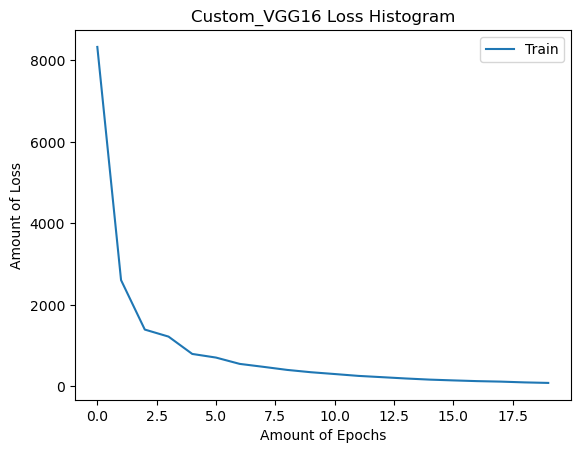

In [12]:
plot_loss(hist)

## Validating the Custom VGG16 Model's Accuracy
To evaluate the custom VGG16 model, an experiment has been established. This experiment involves comparing a batch of test images alongside their ground truth bounding box labels with the model's output. Additionally, it computes the Intersection over Union (IoU) for each image and calculates the IoU for the entire training set.

This validation process offers visual comparisons between the model's predictions and the actual ground truth labels. Furthermore, it quantifies the accuracy using IoU scores, providing insights into the model's performance across the dataset.

The model demonstrates proficient extraction of fruits from images, particularly when presented with single-object images, aligning with its design as a single-box detection model. Challenges arise when confronted with multiple objects within an image, leading to a decline in the overall IoU score. Presently, after 20 epochs, the model achieves an overall IoU score of 58.5%.

In [13]:
def calculate_IoU(box1, box2):
    """
    Calculate IoU (Intersection over Union) between two bounding boxes.
    Each bounding box is represented as a tuple (xmin, ymin, xmax, ymax),
    """

    # Calculate intersection coordinates
    xmin_inter = max(box1[0], box2[0])
    ymin_inter = max(box1[1], box2[1])
    xmax_inter = min(box1[2], box2[2])
    ymax_inter = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, xmax_inter - xmin_inter + 1) * max(0, ymax_inter - ymin_inter + 1)

    # Calculate area of each bounding box
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate and return IoU
    return (intersection_area / union_area)

In [14]:
# Display one image without and one image with bounding boxes.
def plot_bbox_img(img, bounding_boxes_list):

    fig, image = plt.subplots(nrows=1, ncols=2)
    
    for index, item in enumerate(bounding_boxes_list):
        xmin, ymin, xmax, ymax = bounding_boxes_list[index]

        image[index].imshow(img)
        bbox = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        image[index].add_patch(bbox)
        image[index].axis("off")

    plt.show()

1/1 [==============================] - 0s 308ms/step
IoU score:  0.5352252925068459
[ 53  58 130 160] (79, 63, 128, 148)


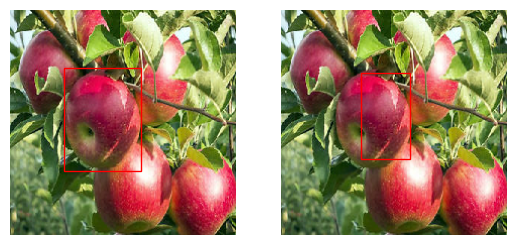

1/1 [==============================] - 0s 129ms/step
IoU score:  0.706205224291855
[  6   5 220 215] (7, 25, 187, 201)


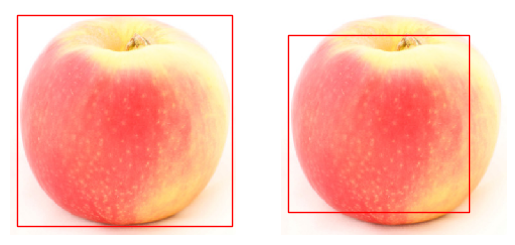

1/1 [==============================] - 0s 129ms/step
IoU score:  0.8371796130806246
[ 23  56 199 222] (35, 50, 199, 210)


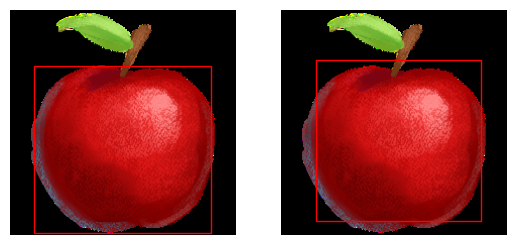

1/1 [==============================] - 0s 124ms/step
IoU score:  0.9010348922694112
[ 57  47 169 195] (53, 53, 171, 193)


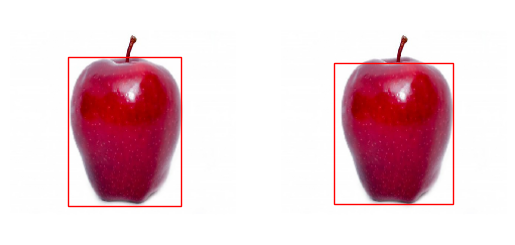

1/1 [==============================] - 0s 117ms/step
IoU score:  0.918487197556965
[ 10  50 207 221] (18, 51, 201, 220)


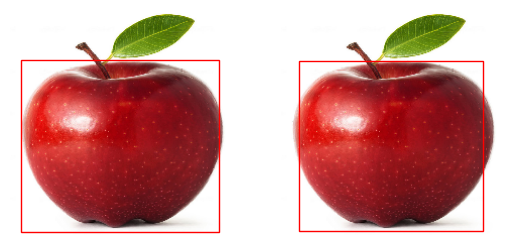

1/1 [==============================] - 0s 122ms/step
IoU score:  0.8592388021058083
[ 35  58 196 192] (31, 53, 186, 188)


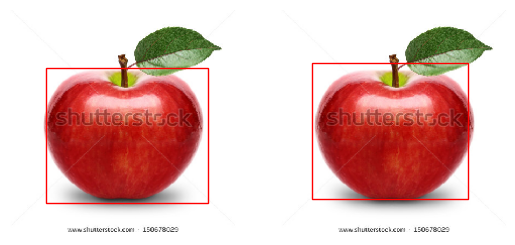

1/1 [==============================] - 0s 131ms/step
IoU score:  0.7363955884135256
[  0   0 222 221] (12, 18, 207, 203)


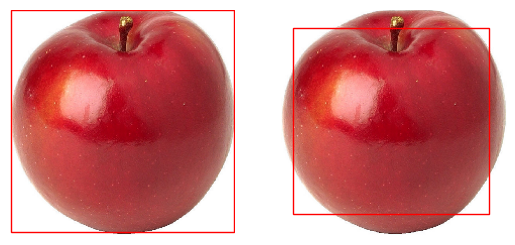

1/1 [==============================] - 0s 131ms/step
IoU score:  0.37663755458515286
[ 16  33 127 181] (58, 44, 190, 183)


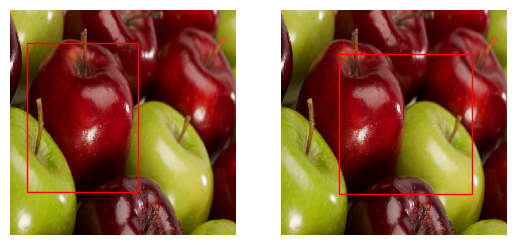

1/1 [==============================] - 0s 122ms/step
IoU score:  0.8977514573887295
[ 39  22 185 220] (32, 23, 194, 220)


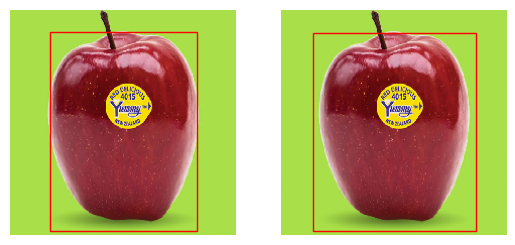

1/1 [==============================] - 0s 120ms/step
IoU score:  0.2761724301279015
[ 59 114  91 167] (39, 83, 113, 166)


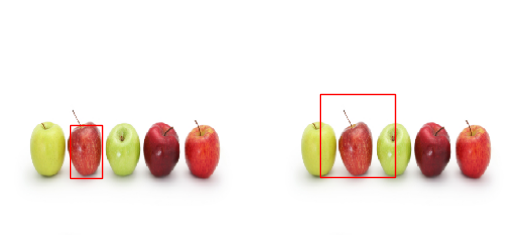

1/1 [==============================] - 0s 109ms/step
IoU score:  0.6232922732362822
[ 20  62 167 212] (47, 60, 197, 199)


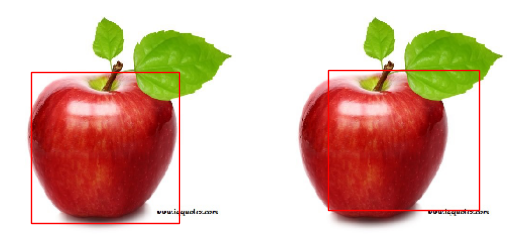

1/1 [==============================] - 0s 129ms/step
IoU score:  0.6459945772738477
[ 41  79 165 211] (21, 69, 152, 195)


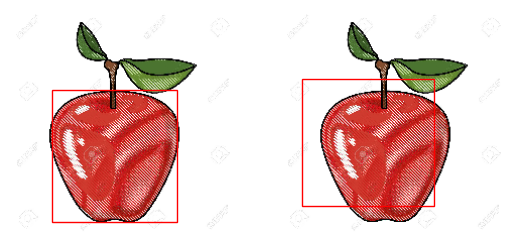

1/1 [==============================] - 0s 117ms/step
IoU score:  0.8912473794549266
[ 13  41 195 211] (17, 34, 203, 213)


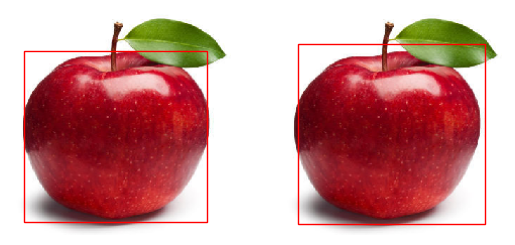

1/1 [==============================] - 0s 118ms/step
IoU score:  0.7478102445518885
[  7  13 219 213] (18, 19, 201, 192)


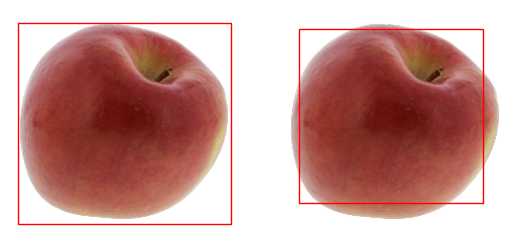

1/1 [==============================] - 0s 130ms/step
IoU score:  0.6794224396402083
[ 52  24 168 195] (60, 38, 188, 211)


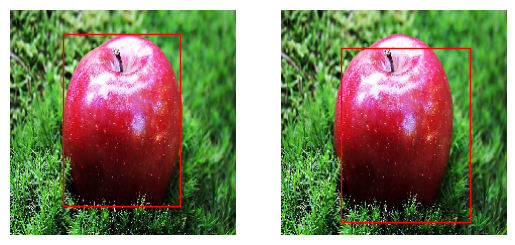

1/1 [==============================] - 0s 118ms/step
IoU score:  0.8613748575769085
[ 28  27 201 193] (22, 18, 195, 188)


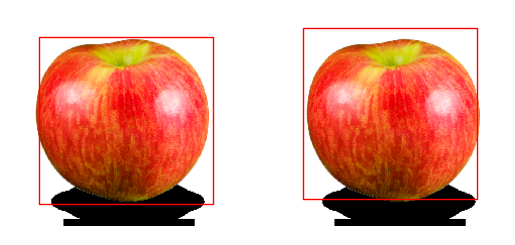

1/1 [==============================] - 0s 112ms/step
IoU score:  0.7479902132121635
[ 60  25 176 221] (45, 32, 166, 211)


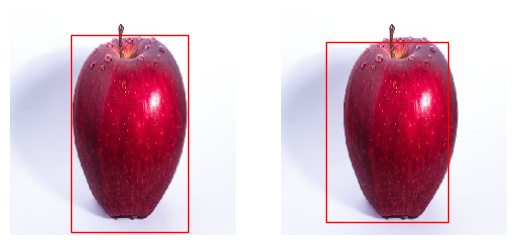

1/1 [==============================] - 0s 118ms/step
IoU score:  0.5554929577464789
[ 40  55 137 213] (51, 41, 167, 190)


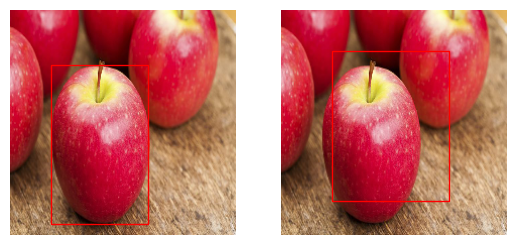

1/1 [==============================] - 0s 115ms/step
IoU score:  0.299575764168389
[ 25  92 110 218] (60, 62, 153, 199)


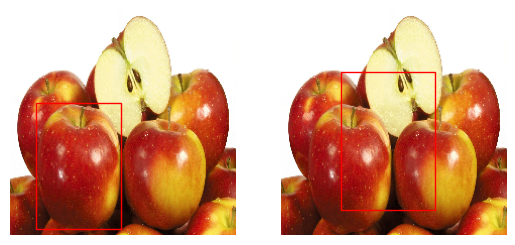

1/1 [==============================] - 0s 113ms/step
IoU score:  0.5464832419081536
[ 21   6 183 216] (50, 60, 186, 201)


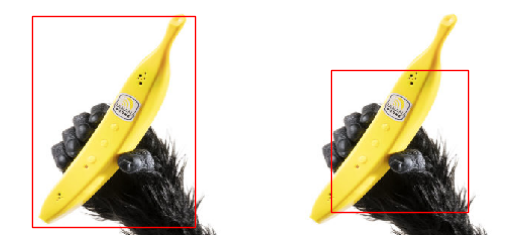

1/1 [==============================] - 0s 108ms/step
IoU score:  0.41817890477907305
[100  31 192 220] (49, 41, 172, 183)


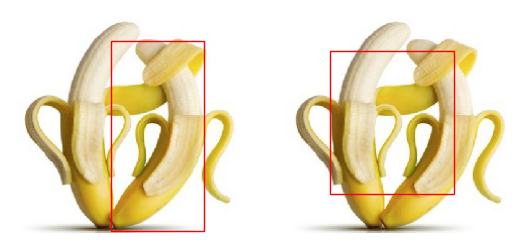

1/1 [==============================] - 0s 115ms/step
IoU score:  0.8733747880158281
[  7  64 212 184] (7, 58, 229, 183)


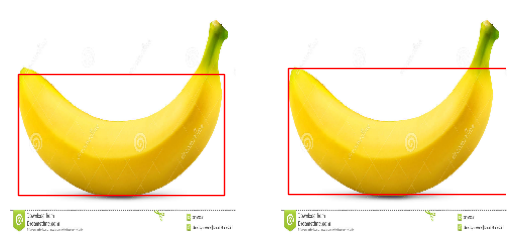

1/1 [==============================] - 0s 112ms/step
IoU score:  0.3943191311612364
[ 19  73 165 124] (48, 77, 176, 172)


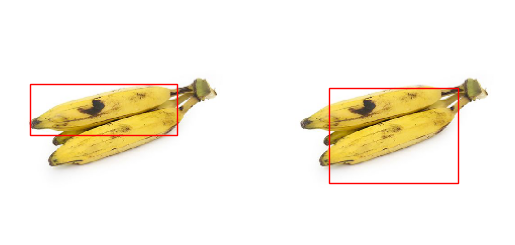

1/1 [==============================] - 0s 132ms/step
IoU score:  0.8832950524551493
[  7  55 193 222] (3, 54, 192, 207)


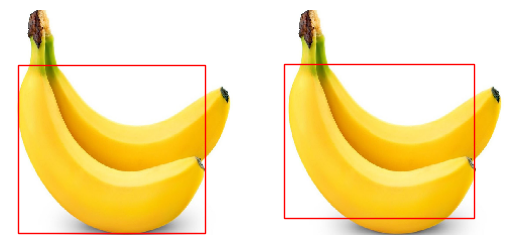

1/1 [==============================] - 0s 132ms/step
IoU score:  0.8712049944411187
[ 29  55 206 176] (29, 51, 195, 182)


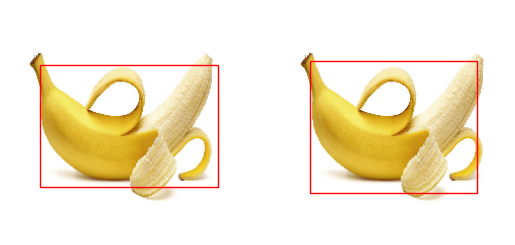

1/1 [==============================] - 0s 130ms/step
IoU score:  0.6905083463886338
[ 22  10 199 203] (46, 38, 214, 203)


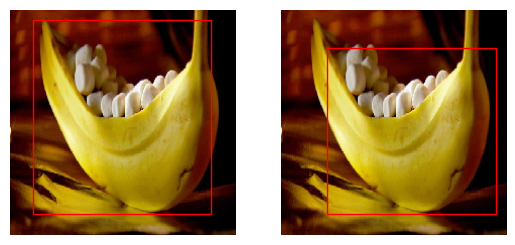

1/1 [==============================] - 0s 138ms/step
IoU score:  0.7068989742869186
[ 29  84 190 215] (35, 87, 213, 238)


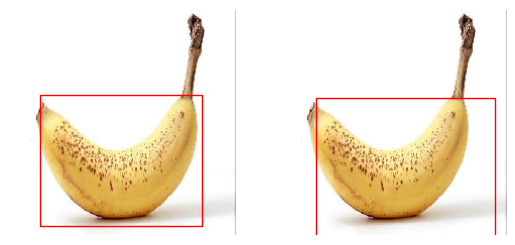

1/1 [==============================] - 0s 132ms/step
IoU score:  0.5452956597727935
[ 35  44 217 153] (46, 40, 162, 139)


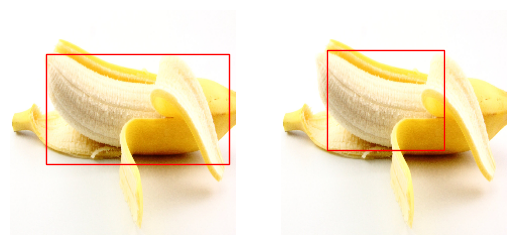

1/1 [==============================] - 0s 125ms/step
IoU score:  0.6544160371876816
[ 53  25 158 210] (35, 31, 186, 200)


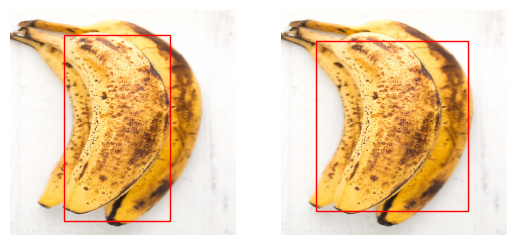

1/1 [==============================] - 0s 118ms/step
IoU score:  0.3429326062878078
[104   2 162 212] (41, 27, 149, 201)


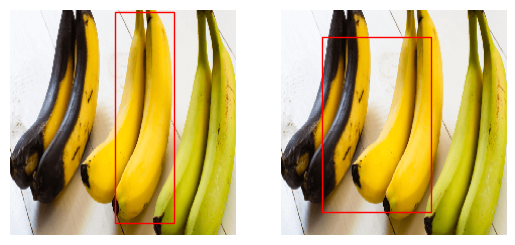

1/1 [==============================] - 0s 151ms/step
IoU score:  0.6831626194038439
[ 62  46 178 184] (57, 41, 167, 157)


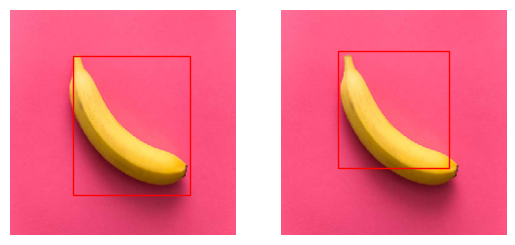

1/1 [==============================] - 0s 119ms/step
IoU score:  0.3501472887951413
[  5 105 189 197] (10, 43, 175, 162)


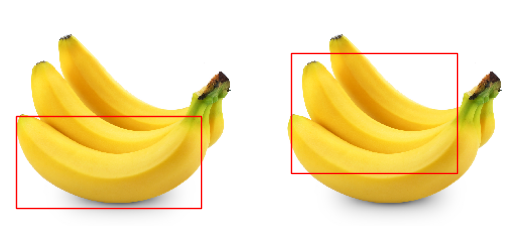

1/1 [==============================] - 0s 116ms/step
IoU score:  0.711340206185567
[ 32  59 127 220] (27, 51, 154, 219)


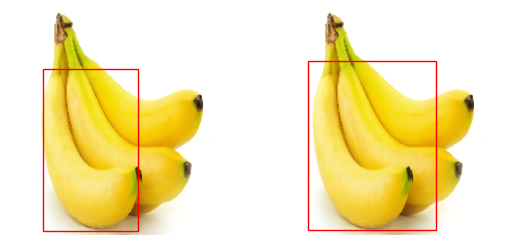

1/1 [==============================] - 0s 128ms/step
IoU score:  0.41191816559110256
[ 34  51  96 193] (47, 44, 137, 170)


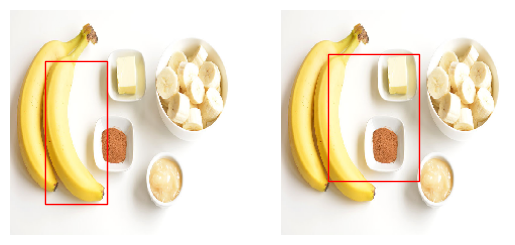

1/1 [==============================] - 0s 125ms/step
IoU score:  0.625614489003881
[  3   7 216 222] (2, 31, 188, 186)


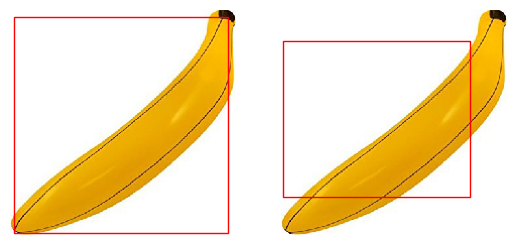

1/1 [==============================] - 0s 119ms/step
IoU score:  0.1614693446088795
[ 49  31 189  94] (47, 69, 193, 186)


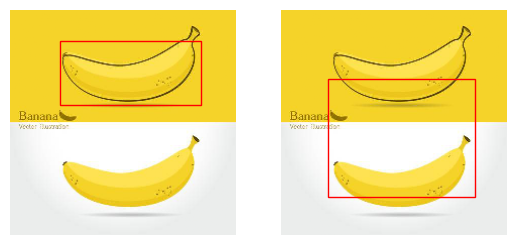

1/1 [==============================] - 0s 116ms/step
IoU score:  0.5523140495867769
[  0   2 219 221] (52, 12, 214, 175)


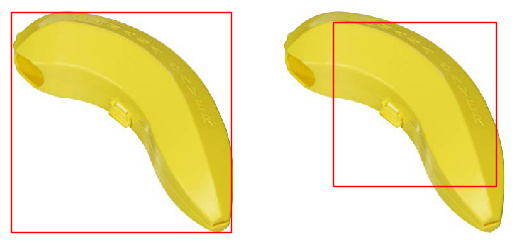

1/1 [==============================] - 0s 108ms/step
IoU score:  0.5753968253968254
[ 37 102  94 181] (30, 88, 101, 199)


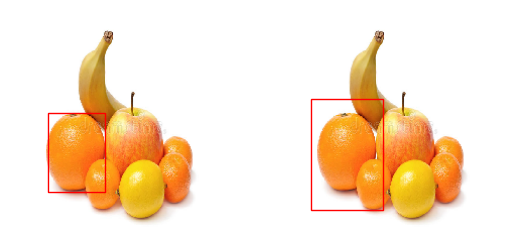

1/1 [==============================] - 0s 110ms/step
IoU score:  0.12909292406891223
[  0 124 204 220] (81, 54, 216, 154)


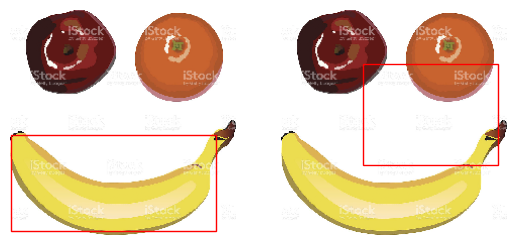

1/1 [==============================] - 0s 126ms/step
IoU score:  0.1269970489467793
[ 21  40  73 118] (48, 71, 131, 152)


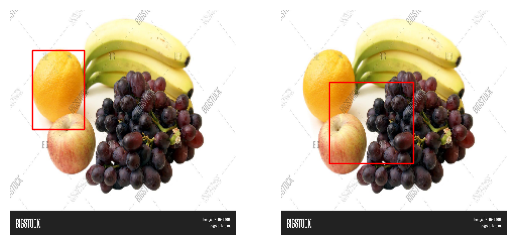

1/1 [==============================] - 0s 113ms/step
IoU score:  0.3064481804639285
[ 55  31 134 156] (31, 67, 163, 221)


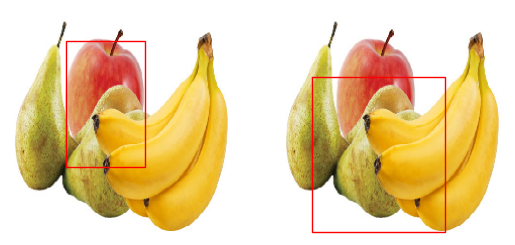

1/1 [==============================] - 0s 111ms/step
IoU score:  0.4274388142019993
[113  58 199 189] (71, 51, 172, 181)


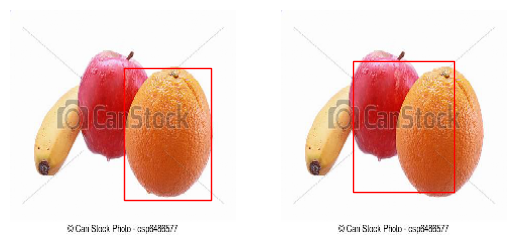

1/1 [==============================] - 0s 127ms/step
IoU score:  0.0
[  0  50  39 121] (48, 58, 168, 172)


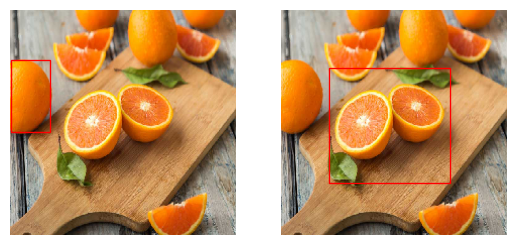

1/1 [==============================] - 0s 138ms/step
IoU score:  0.6213379973764758
[101  10 204 222] (74, 16, 187, 211)


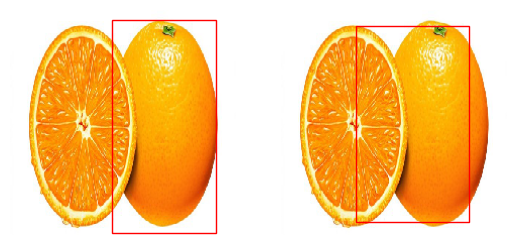

1/1 [==============================] - 0s 119ms/step
IoU score:  0.20907127429805616
[  8 102 106 187] (63, 78, 154, 167)


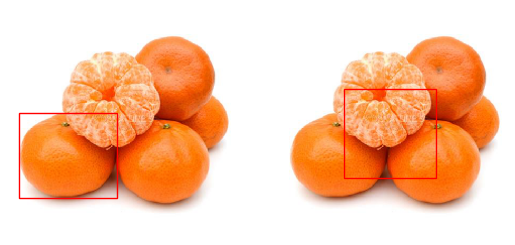

1/1 [==============================] - 0s 129ms/step
IoU score:  0.8195541513077058
[ 22  32 137 195] (6, 35, 141, 199)


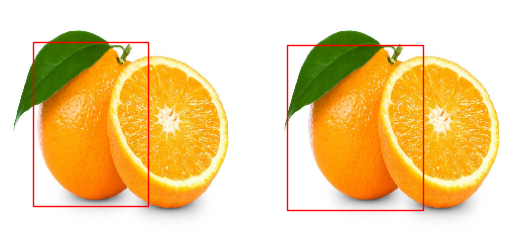

1/1 [==============================] - 0s 161ms/step
IoU score:  0.3392746966477
[ 15  64 104 183] (56, 61, 139, 164)


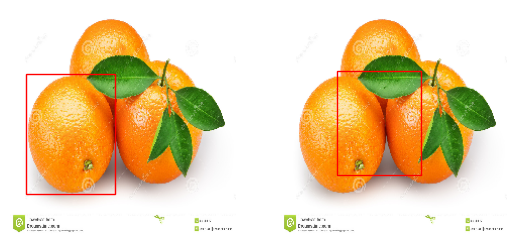

1/1 [==============================] - 0s 141ms/step
IoU score:  0.8597861842105263
[ 21  44 143 162] (19, 39, 146, 171)


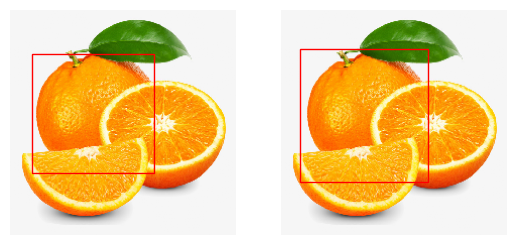

1/1 [==============================] - 0s 141ms/step
IoU score:  0.8359520484171322
[ 21  17 199 208] (21, 20, 189, 189)


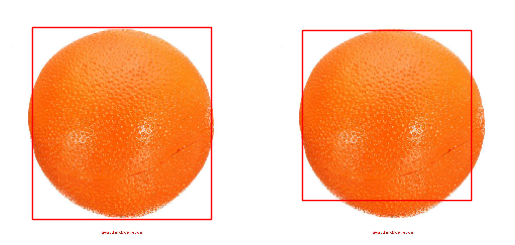

1/1 [==============================] - 0s 145ms/step
IoU score:  0.8365867261572784
[ 70  22 205 177] (86, 27, 207, 176)


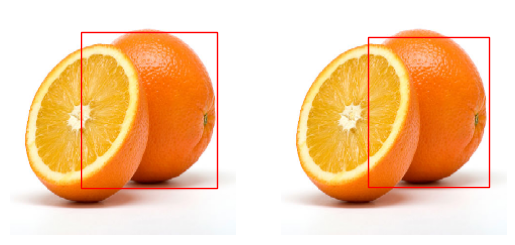

1/1 [==============================] - 0s 136ms/step
IoU score:  0.6615587765630758
[ 16  60 204 204] (38, 31, 206, 188)


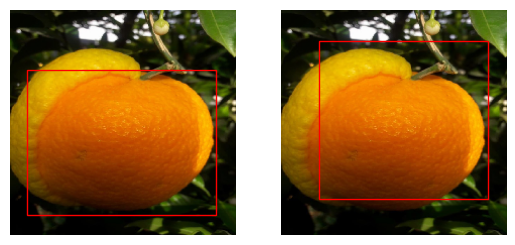

1/1 [==============================] - 0s 136ms/step
IoU score:  0.36982968369829683
[ 77 101 171 209] (45, 78, 152, 174)


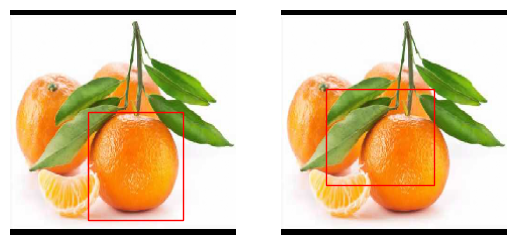

1/1 [==============================] - 0s 148ms/step
IoU score:  0.348145285935085
[ 10 107  83 184] (31, 82, 118, 174)


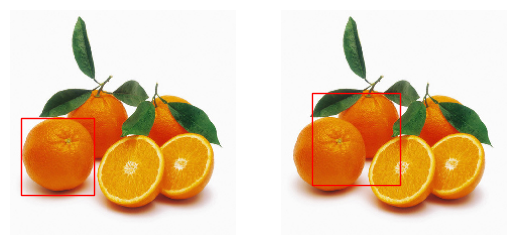

1/1 [==============================] - 0s 125ms/step
IoU score:  0.35224247388900265
[ 18  23  99 147] (57, 22, 135, 142)


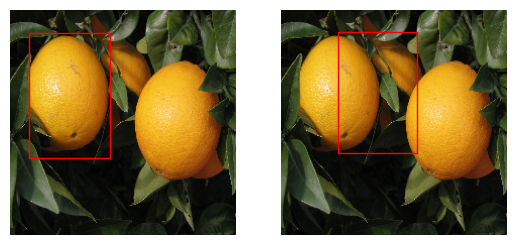

1/1 [==============================] - 0s 142ms/step
IoU score:  0.3371725803455322
[ 26  34 121 152] (67, 54, 156, 166)


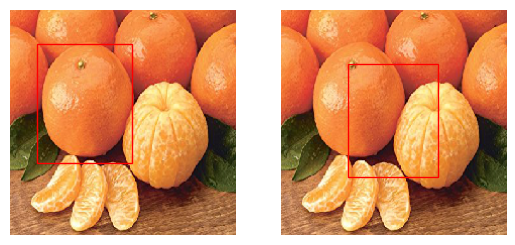

1/1 [==============================] - 0s 133ms/step
IoU score:  0.710140736456526
[ 46  30 178 185] (55, 43, 160, 181)


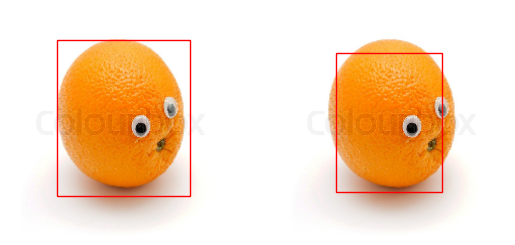

1/1 [==============================] - 0s 135ms/step
IoU score:  0.47586561375636655
[ 99  17 209 175] (71, 38, 174, 171)


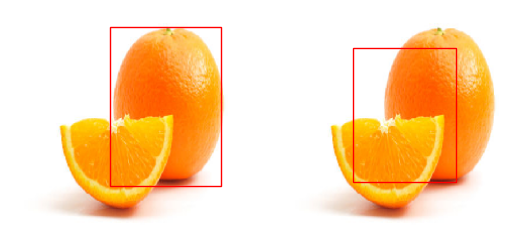

1/1 [==============================] - 0s 124ms/step
IoU score:  0.5555156564205688
[ 34  67 113 190] (49, 72, 139, 200)


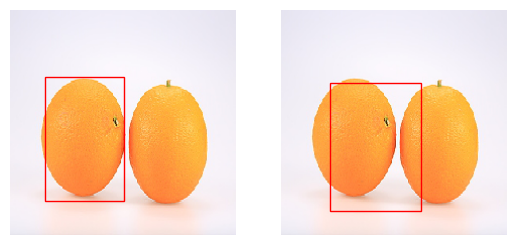

1/1 [==============================] - 0s 129ms/step
IoU score:  0.8541610192464082
[ 61  32 204 176] (59, 25, 198, 168)


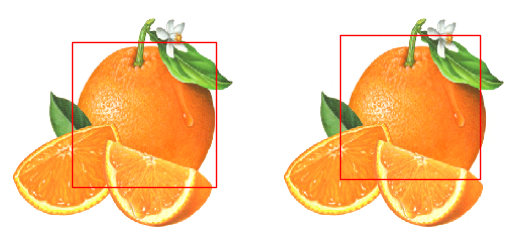

1/1 [==============================] - 0s 127ms/step
IoU score:  0.8398691581757342
[ 24  58 183 203] (31, 56, 195, 210)


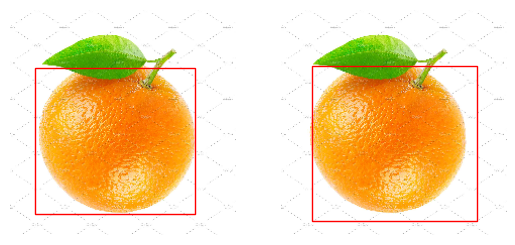

Total IoU Score:  0.5851806752504569


In [15]:
score=0
# Loop through the image filenames and process each image
for index, item in enumerate(Test_Images):
    image = np.expand_dims(Test_Images[index], axis=0)
    Pred_Bbox_Label = tuple(map(int, Custom_VGG16.predict(image)[0]))
    print("IoU score: ", calculate_IoU(Pred_Bbox_Label, Test_Bbox_Labels[index]))
    score += calculate_IoU(Pred_Bbox_Label, Test_Bbox_Labels[index])
    print(Test_Bbox_Labels[index], Pred_Bbox_Label)
    plot_bbox_img(Test_Images[index], [Test_Bbox_Labels[index], Pred_Bbox_Label])

print("Total IoU Score: ", score/len(Test_Images))